#### Важное требование ко всей домашке в целом: в jupyter ноутбуке не должно был лишнего кода (т.е. если вы взяли за основу семинар, не забудьте удалить все лишнее)

# Задание 1 (3 балла)

Обучите word2vec модели с негативным семплированием (cbow и skip-gram) с помощью tensorflow аналогично тому, как это было сделано в семинаре. Вам нужно изменить следующие пункты: 
1) добавьте лемматизацию в предобработку (любым способом)  
2) измените размер окна на 6 для cbow и 12 для skip gram (обратите внимание, что размер окна = #слов слева + #слов справа, в gen_batches в семинаре window используется не так и вам нужно это изменить!)

Выберете несколько не похожих по смыслу слов, и протестируйте полученные эмбединги (найдите ближайшие слова и оцените правильность, как в семинаре)

In [328]:
import tensorflow as tf
import numpy as np
import re
import pandas as pd
from pymystem3 import Mystem
from string import punctuation
from sklearn.model_selection import train_test_split
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_distances

from IPython.display import Image
from IPython.core.display import HTML
%matplotlib inline

In [329]:
def preprocess(p_text):
    p_tokens = re.sub('#+', ' ', p_text.lower()).split()
    p_tokens = [token.strip(punctuation) for token in p_tokens]
    p_tokens = [token for token in p_tokens if token]
    return p_tokens

In [330]:
wiki = open('wiki_data.txt', encoding='UTF8').read().split('\n')

In [331]:
vocab = Counter()

for text in wiki:
    vocab.update(preprocess(text))

In [332]:
filtered_vocab = set()

for word in vocab:
    if vocab[word] > 30:
        filtered_vocab.add(word)

In [333]:
len(filtered_vocab)

17016

In [334]:
mystem = Mystem()
lemmatized_vocab = set(mystem.lemmatize(' '.join(filtered_vocab)))
len(lemmatized_vocab)

7311

In [335]:
word2id = {'PAD': 0}

for word in lemmatized_vocab:
    word2id[word] = len(word2id)
id2word = {i: word for word, i in word2id.items()}

In [336]:
len(word2id)

7312

In [337]:
sentences = []

for text in wiki:
    tokens = preprocess(text)
    if not tokens:
        continue
    ids = [word2id[token] for token in tokens if token in word2id]
    sentences.append(ids)

In [338]:
vocab_size = len(id2word)

In [339]:
len(id2word)

7312

In [340]:
# skip gram
def gen_batches_sg(sentences, window = 12, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                half_window = window // 2
                context = sent[max(0, i-half_window):i] + sent[i+1:i+half_window+1]
                for context_word in context:
                    X_target.append(word)
                    X_context.append(context_word)
                    y.append(1)

                    X_target.append(word)
                    X_context.append(np.random.randint(vocab_size))
                    y.append(0)

                    if len(X_target) >= batch_size:
                        X_target = np.array(X_target)
                        X_context = np.array(X_context)
                        y = np.array(y)
                        yield ((X_target, X_context), y)
                        X_target = []
                        X_context = []
                        y = []

In [341]:
# # cbow
def gen_batches_cbow(sentences, window = 6, batch_size=1000):
    while True:
        X_target = []
        X_context = []
        y = []

        for sent in sentences:
            for i in range(len(sent)-1):
                word = sent[i]
                half_window = window // 2
                context = sent[max(0, i-half_window):i] + sent[i+1:i+half_window+1]

                X_target.append(word)
                X_context.append(context)
                y.append(1)

                X_target.append(np.random.randint(vocab_size))
                X_context.append(context)
                y.append(0)

                if len(X_target) == batch_size:
                    X_target = np.array(X_target)
                    X_context = tf.keras.preprocessing.sequence.pad_sequences(X_context, maxlen=window)
                    y = np.array(y)
                    yield ((X_target, X_context), y)
                    X_target = []
                    X_context = []
                    y = []

In [342]:
# skip gram
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(1,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Flatten()(embeddings_context)

dot = tf.keras.layers.Dot(1)([target, context])
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_neg_skip = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_neg_skip.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [343]:
model_neg_skip.fit(gen_batches_sg(sentences[:19000], window=12),
          validation_data=gen_batches_sg(sentences[19000:], window=12),
          batch_size=1000,
          steps_per_epoch=10000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
10000/10000 [==============================] - 250s 25ms/step - loss: 0.3552 - accuracy: 0.8518 - val_loss: 0.3642 - val_accuracy: 0.8561
Epoch 2/2
10000/10000 [==============================] - 260s 26ms/step - loss: 0.3298 - accuracy: 0.8640 - val_loss: 0.3125 - val_accuracy: 0.8756


In [344]:
def most_similar(word, embeddings):
    similar = [id2word[i] for i in
               cosine_distances(embeddings[word2id[word]].reshape(1, -1), embeddings).argsort()[0][:10]]
    return similar

In [345]:
embeddings = model_neg_skip.layers[2].get_weights()[0]

In [346]:
embeddings.shape

(7312, 300)

In [347]:
most_similar('церковь', embeddings)

['церковь',
 'храм',
 'пресвятой',
 'каменный',
 'монастырь',
 'честь',
 'xix',
 'здесь',
 'собор',
 'памятник']

In [348]:
#cbow negative sampling
inputs_target = tf.keras.layers.Input(shape=(1,))
inputs_context = tf.keras.layers.Input(shape=(10,))

embeddings_target = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_target, )
embeddings_context = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=300)(inputs_context, )

target = tf.keras.layers.Flatten()(embeddings_target)
context = tf.keras.layers.Lambda(lambda x: tf.keras.backend.sum(x, axis=1))(embeddings_context)
dot = tf.keras.layers.Dot(1)([target, context])

# полученную близость нужно преобразовать в вероятность
# когда она одна используется не софтмакс и сигмоида
outputs = tf.keras.layers.Activation(activation='sigmoid')(dot)

model_neg_cbow = tf.keras.Model(inputs=[inputs_target, inputs_context],
                       outputs=outputs)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model_neg_cbow.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])



In [349]:
model_neg_cbow.fit(gen_batches_cbow(sentences[:19000], window=6),
          validation_data=gen_batches_cbow(sentences[19000:], window=6),
          batch_size=1000,
          steps_per_epoch=5000,
          validation_steps=30,
          epochs=2)

Epoch 1/2
5000/5000 [==============================] - 121s 24ms/step - loss: 0.2885 - accuracy: 0.8816 - val_loss: 0.2572 - val_accuracy: 0.8978
Epoch 2/2
5000/5000 [==============================] - 107s 21ms/step - loss: 0.2111 - accuracy: 0.9138 - val_loss: 0.2386 - val_accuracy: 0.9054


In [350]:
embeddings = model_neg_cbow.layers[2].get_weights()[0]

In [351]:
most_similar('семья', embeddings)

['семья',
 'петербург',
 'детство',
 '1882',
 'лос-анджелес',
 'оттуда',
 'когда-то',
 'учиться',
 'мама',
 'преподавать']

# Задание 2 (3 балла)

Обучите 1 word2vec и 1 fastext модель в gensim. В каждой из модели нужно задать все параметры, которые мы разбирали на семинаре. Заданные значения должны отличаться от дефолтных и от тех, что мы использовали на семинаре.

In [352]:
import gensim

In [353]:
wiki = open('wiki_data.txt', encoding='UTF8').read().split('\n')

In [354]:
texts = [preprocess(text) for text in wiki]

In [355]:
%%time
w2v_vector_size = 500
w2v = gensim.models.Word2Vec(texts,
                             vector_size=w2v_vector_size,
                             min_count=10,
                             max_vocab_size=15000,
                             window=10,
                             epochs=10,
                             sg=0,
                             hs=1,
                             negative=15,
                             sample=1e-6,
                             ns_exponent=0.9,
                             cbow_mean=0
                            )

Wall time: 6.12 s


In [356]:
w2v.wv.most_similar('церковь')

[('власти', 0.9664920568466187),
 ('хутора', 0.9629204869270325),
 ('империи', 0.9608736634254456),
 ('станицы', 0.9603092074394226),
 ('входят', 0.9602205753326416),
 ('имеется', 0.9564201831817627),
 ('недалеко', 0.956389844417572),
 ('революции', 0.9560890197753906),
 ('жителей', 0.9533519744873047),
 ('дорога', 0.9530216455459595)]

In [357]:
%%time
ft_vector_size = 300
ft = gensim.models.FastText(texts, min_n=4, max_n=7, vector_size=ft_vector_size, window=2, min_count=6, sample=1e-4, sg=0,hs=1, negative=6)

Wall time: 1min 26s


In [358]:
ft.wv.most_similar('церковь')

[('«церковь', 0.9794607162475586),
 ('церковь»', 0.9729459881782532),
 ('це́рковь', 0.8935835361480713),
 ('церковью', 0.8693404197692871),
 ('морковь', 0.768290638923645),
 ('церковная', 0.7579393982887268),
 ('часовня', 0.7346314191818237),
 ('церквям', 0.7231943607330322),
 ('церкви»', 0.7155362963676453),
 ('церкви', 0.6968863010406494)]

# Задание 3 (4 балла)

Используя датасет для классификации (labeled.csv) и простую нейронную сеть (последняя модель в семинаре), оцените качество полученных эмбедингов в задании 1 и 2 (4 набора эмбедингов), также проверьте 1 любую из предобученных моделей с rus-vectores (но только не tayga_upos_skipgram_300_2_2019). 
Какая модель показывает наилучший результат?

Убедитесь, что для каждой модели вы корректно воспроизводите пайплайн предобработки (в 1 задании у вас лемматизация, не забудьте ее применить к датасету для классификации; у выбранной предобученной модели может быть своя специфичная предобработка - ее нужно воспроизвести)

In [359]:
def preprocess(p_text):
    p_tokens = re.sub('#+', ' ', p_text.lower()).split()
    p_tokens = [token.strip(punctuation) for token in p_tokens]
    p_tokens = [token for token in p_tokens if token]
    return p_tokens

In [360]:
data = pd.read_csv('labeled.csv', encoding='UTF8')

In [361]:
data['norm_text'] = data.comment.apply(preprocess)

In [362]:
data

,comment,toxic,norm_text
0,"Верблюдов-то за что? Дебилы, бл...\r\n",1.0,"[верблюдов-то, за, что, дебилы, бл]"
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0,"[хохлы, это, отдушина, затюканого, россиянина,..."
2,Собаке - собачья смерть\r\n,1.0,"[собаке, собачья, смерть]"
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0,"[страницу, обнови, дебил, это, тоже, не, оскор..."
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0,"[тебя, не, убедил, 6-страничный, пдф, в, том, ..."
...,...,...,...
14407,Вонючий совковый скот прибежал и ноет. А вот и...,1.0,"[вонючий, совковый, скот, прибежал, и, ноет, а..."
14408,А кого любить? Гоблина тупорылого что-ли? Или ...,1.0,"[а, кого, любить, гоблина, тупорылого, что-ли,..."
14409,"Посмотрел Утомленных солнцем 2. И оказалось, ч...",0.0,"[посмотрел, утомленных, солнцем, 2, и, оказало..."
14410,КРЫМОТРЕД НАРУШАЕТ ПРАВИЛА РАЗДЕЛА Т.К В НЕМ Н...,1.0,"[крымотред, нарушает, правила, раздела, т.к, в..."


In [363]:
vocab = Counter()

for text in data['norm_text']:
    vocab.update(text)

filtered_vocab = set()

for word in vocab:
    if vocab[word] > 5:
        filtered_vocab.add(word)

len(filtered_vocab)

7231

In [364]:
mystem = Mystem()
lemmatized_vocab = set(mystem.lemmatize(' '.join(filtered_vocab)))
len(lemmatized_vocab)

3627

In [365]:
word2id = { 'PAD':0}

for word in lemmatized_vocab:
    word2id[word] = len(word2id)
id2word = {i:word for word, i in word2id.items()}
len(word2id)

3628

# 1 модель

In [366]:
X = []
for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [367]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=ft_vector_size)
y = data.toxic.values

In [368]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [369]:
inputs = tf.keras.layers.Input(shape=(ft_vector_size,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=ft_vector_size)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [370]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 4s 9ms/step - loss: 0.6337 - accuracy: 0.6650 - val_loss: 0.6175 - val_accuracy: 0.6685
Epoch 2/30
428/428 [==============================] - 4s 9ms/step - loss: 0.6067 - accuracy: 0.6652 - val_loss: 0.5867 - val_accuracy: 0.6699
Epoch 3/30
428/428 [==============================] - 4s 9ms/step - loss: 0.5719 - accuracy: 0.6846 - val_loss: 0.5539 - val_accuracy: 0.6796
Epoch 4/30
428/428 [==============================] - 4s 9ms/step - loss: 0.5278 - accuracy: 0.7292 - val_loss: 0.5246 - val_accuracy: 0.7198
Epoch 5/30
428/428 [==============================] - 4s 9ms/step - loss: 0.4871 - accuracy: 0.7666 - val_loss: 0.5023 - val_accuracy: 0.7601
Epoch 6/30
428/428 [==============================] - 4s 9ms/step - loss: 0.4596 - accuracy: 0.7877 - val_loss: 0.4896 - val_accuracy: 0.7892
Epoch 7/30
428/428 [==============================] - 4s 9ms/step - loss: 0.4378 - accuracy: 0.8031 - val_loss: 0.4801 - val_accuracy: 0.7920
Epoch 

In [371]:
weights = np.zeros((len(word2id), ft_vector_size))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = ft.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = ft.wv['опрагпллирао']

In [372]:
inputs = tf.keras.layers.Input(shape=(ft_vector_size,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=ft_vector_size,
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_ft = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model_ft.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [373]:
model_ft.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 4s 9ms/step - loss: 0.6264 - accuracy: 0.6647 - val_loss: 0.6094 - val_accuracy: 0.6685
Epoch 2/30
428/428 [==============================] - 4s 9ms/step - loss: 0.6094 - accuracy: 0.6654 - val_loss: 0.6001 - val_accuracy: 0.6852
Epoch 3/30
428/428 [==============================] - 4s 9ms/step - loss: 0.5862 - accuracy: 0.6699 - val_loss: 0.5683 - val_accuracy: 0.6879
Epoch 4/30
428/428 [==============================] - 4s 9ms/step - loss: 0.5541 - accuracy: 0.7014 - val_loss: 0.5422 - val_accuracy: 0.7143
Epoch 5/30
428/428 [==============================] - 4s 9ms/step - loss: 0.5192 - accuracy: 0.7354 - val_loss: 0.5262 - val_accuracy: 0.7795
Epoch 6/30
428/428 [==============================] - 4s 9ms/step - loss: 0.4883 - accuracy: 0.7651 - val_loss: 0.5057 - val_accuracy: 0.7517
Epoch 7/30
428/428 [==============================] - 4s 9ms/step - loss: 0.4643 - accuracy: 0.7850 - val_loss: 0.4956 - val_accuracy: 0.7642
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


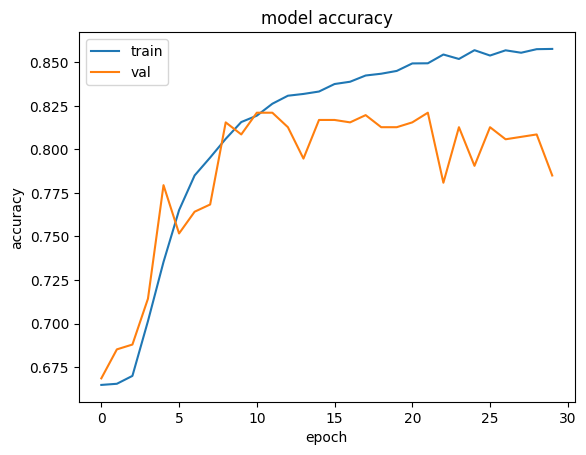

In [374]:
print(model_ft.history.history.keys())
# summarize history for accuracy
plt.plot(model_ft.history.history['accuracy'])
plt.plot(model_ft.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 2 модель

In [375]:
X = []
for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)

In [376]:
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=w2v_vector_size)
y = data.toxic.values

In [377]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [378]:
inputs = tf.keras.layers.Input(shape=(w2v_vector_size,))

embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=w2v_vector_size)(inputs, )
# embedding слой возвращает последовательность векторов
# а нам нужно классифицировать сразу весь текст
# стандартный подход в этом случае - усреднить единичные вектора в 1 вектор текста
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)
# к усредненному вектору мы уже применяем полносвязный слой, который вернет вероятность токсичности
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [379]:
model.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 8s 17ms/step - loss: 0.6354 - accuracy: 0.6646 - val_loss: 0.6245 - val_accuracy: 0.6671
Epoch 2/30
428/428 [==============================] - 7s 17ms/step - loss: 0.6174 - accuracy: 0.6655 - val_loss: 0.6000 - val_accuracy: 0.6671
Epoch 3/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5909 - accuracy: 0.6700 - val_loss: 0.5709 - val_accuracy: 0.6879
Epoch 4/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5568 - accuracy: 0.7062 - val_loss: 0.5412 - val_accuracy: 0.6976
Epoch 5/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5161 - accuracy: 0.7422 - val_loss: 0.5148 - val_accuracy: 0.7171
Epoch 6/30
428/428 [==============================] - 7s 17ms/step - loss: 0.4863 - accuracy: 0.7673 - val_loss: 0.4975 - val_accuracy: 0.7906
Epoch 7/30
428/428 [==============================] - 7s 17ms/step - loss: 0.4613 - accuracy: 0.7869 - val_loss: 0.4900 - val_accuracy: 0.8017

In [380]:
weights = np.zeros((len(word2id), w2v_vector_size))

for word, i in word2id.items():
    # вектор паддинга оставим нулевым
    if word == 'PAD':
        continue

    try:
        weights[i] = w2v.wv[word]


    except KeyError:
        # для слов, которых нет в модели тоже возьмем какой-то  рандомный вектор
        continue
        weights[i] = w2v.wv['опрагпллирао']

In [381]:
inputs = tf.keras.layers.Input(shape=(w2v_vector_size,))

# передаем матрицу в эмбединг слой
# указываем параметр trainable=False, чтобы вектора не обучались
# Пояснение: кажется, что обучение векторов отключать не стоит, так как модель должна взять готовые
# эмбединги и подогнать их к нашей задаче. На практитке это однако не работает - эмбединги просто
# обучатся заново
embeddings = tf.keras.layers.Embedding(input_dim=len(word2id), output_dim=w2v_vector_size,
                                       trainable=True,
                                       weights=[weights])(inputs, )
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x,  axis=1))(embeddings)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

model_w2v = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
model_w2v.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [382]:
model_w2v.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 8s 17ms/step - loss: 0.6347 - accuracy: 0.6650 - val_loss: 0.6252 - val_accuracy: 0.6671
Epoch 2/30
428/428 [==============================] - 7s 17ms/step - loss: 0.6170 - accuracy: 0.6650 - val_loss: 0.6010 - val_accuracy: 0.6671
Epoch 3/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5930 - accuracy: 0.6729 - val_loss: 0.5721 - val_accuracy: 0.6768
Epoch 4/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5544 - accuracy: 0.7063 - val_loss: 0.5359 - val_accuracy: 0.7157
Epoch 5/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5094 - accuracy: 0.7498 - val_loss: 0.5041 - val_accuracy: 0.7601
Epoch 6/30
428/428 [==============================] - 7s 17ms/step - loss: 0.4731 - accuracy: 0.7780 - val_loss: 0.4851 - val_accuracy: 0.7906
Epoch 7/30
428/428 [==============================] - 7s 17ms/step - loss: 0.4532 - accuracy: 0.7939 - val_loss: 0.4706 - val_accuracy: 0.7892

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


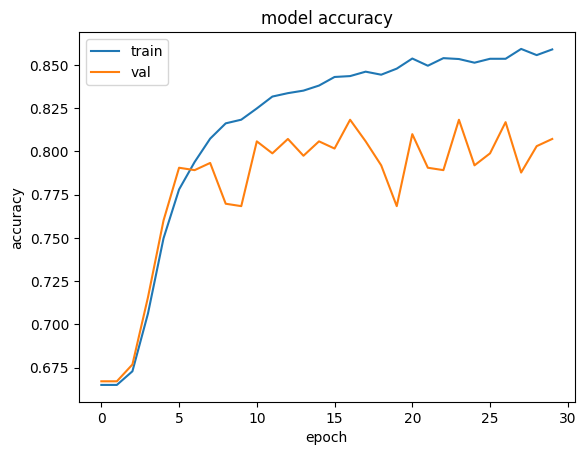

In [383]:
print(model_w2v.history.history.keys())
# summarize history for accuracy
plt.plot(model_w2v.history.history['accuracy'])
plt.plot(model_w2v.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 3 модель

In [384]:
# Get the weights of the target embedding layer
embeddings_loaded = model_neg_skip.layers[2].get_weights()[0]

In [385]:
embeddings_loaded.shape

(7312, 300)

In [386]:
X = []
for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [387]:
# Create an input layer with the correct shape
inputs = tf.keras.layers.Input(shape=(None,))

# Create an embedding layer
embeddings = tf.keras.layers.Embedding(input_dim=embeddings_loaded.shape[0], output_dim=300, trainable=True)(inputs)

# Compute the mean of the embeddings
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)

# Create an output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

# Create a model
model_skip = tf.keras.Model(inputs=inputs, outputs=outputs)

# Set the weights of the embedding layer
model_skip.layers[1].set_weights([embeddings_loaded])

# Compile the model
optimizer = tf.keras.optimizers.Adam()
model_skip.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [388]:
model_skip.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 9s 20ms/step - loss: 0.6341 - accuracy: 0.6634 - val_loss: 0.6103 - val_accuracy: 0.6782
Epoch 2/30
428/428 [==============================] - 8s 18ms/step - loss: 0.6097 - accuracy: 0.6647 - val_loss: 0.6011 - val_accuracy: 0.6782
Epoch 3/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5763 - accuracy: 0.6819 - val_loss: 0.5514 - val_accuracy: 0.6824
Epoch 4/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5345 - accuracy: 0.7260 - val_loss: 0.5161 - val_accuracy: 0.7171
Epoch 5/30
428/428 [==============================] - 7s 17ms/step - loss: 0.4956 - accuracy: 0.7604 - val_loss: 0.4966 - val_accuracy: 0.8044
Epoch 6/30
428/428 [==============================] - 7s 17ms/step - loss: 0.4636 - accuracy: 0.7875 - val_loss: 0.4774 - val_accuracy: 0.7920
Epoch 7/30
428/428 [==============================] - 7s 17ms/step - loss: 0.4418 - accuracy: 0.7982 - val_loss: 0.4660 - val_accuracy: 0.7864

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


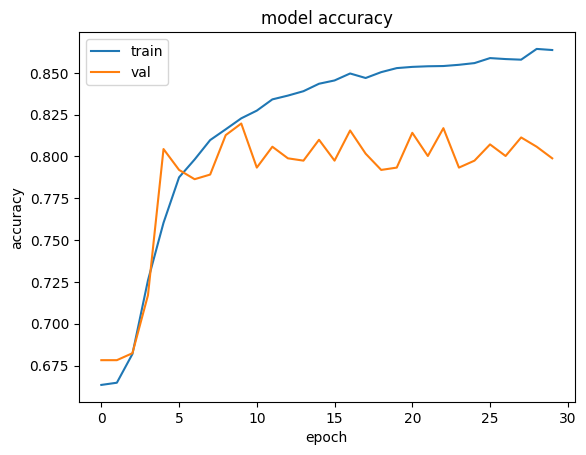

In [389]:
print(model_skip.history.history.keys())
# summarize history for accuracy
plt.plot(model_skip.history.history['accuracy'])
plt.plot(model_skip.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 4 модель

In [390]:
embeddings_loaded = model_neg_cbow.layers[2].get_weights()[0]
embeddings_loaded.shape

(7312, 300)

In [391]:
X = []
for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [392]:
# Create an input layer with the correct shape
inputs = tf.keras.layers.Input(shape=(None,))

# Create an embedding layer
embeddings = tf.keras.layers.Embedding(input_dim=embeddings_loaded.shape[0], output_dim=300, trainable=True)(inputs)

# Compute the mean of the embeddings
mean = tf.keras.layers.Lambda(lambda x: tf.keras.backend.mean(x, axis=1))(embeddings)

# Create an output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)

# Create a model
model_cbow = tf.keras.Model(inputs=inputs, outputs=outputs)

# Set the weights of the embedding layer
model_cbow.layers[1].set_weights([embeddings_loaded])

# Compile the model
optimizer = tf.keras.optimizers.Adam()
model_cbow.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [393]:
model_cbow.fit(X_train, y_train,
          validation_data=(X_valid, y_valid),
          batch_size=32,
         epochs=30)

Epoch 1/30
428/428 [==============================] - 9s 19ms/step - loss: 0.6362 - accuracy: 0.6635 - val_loss: 0.6065 - val_accuracy: 0.6963
Epoch 2/30
428/428 [==============================] - 9s 20ms/step - loss: 0.6238 - accuracy: 0.6635 - val_loss: 0.5999 - val_accuracy: 0.6963
Epoch 3/30
428/428 [==============================] - 10s 23ms/step - loss: 0.6108 - accuracy: 0.6646 - val_loss: 0.5892 - val_accuracy: 0.6963
Epoch 4/30
428/428 [==============================] - 10s 23ms/step - loss: 0.5961 - accuracy: 0.6658 - val_loss: 0.5796 - val_accuracy: 0.7060
Epoch 5/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5788 - accuracy: 0.6740 - val_loss: 0.5605 - val_accuracy: 0.7143
Epoch 6/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5570 - accuracy: 0.6991 - val_loss: 0.5395 - val_accuracy: 0.7351
Epoch 7/30
428/428 [==============================] - 7s 17ms/step - loss: 0.5376 - accuracy: 0.7151 - val_loss: 0.5195 - val_accuracy: 0.73

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


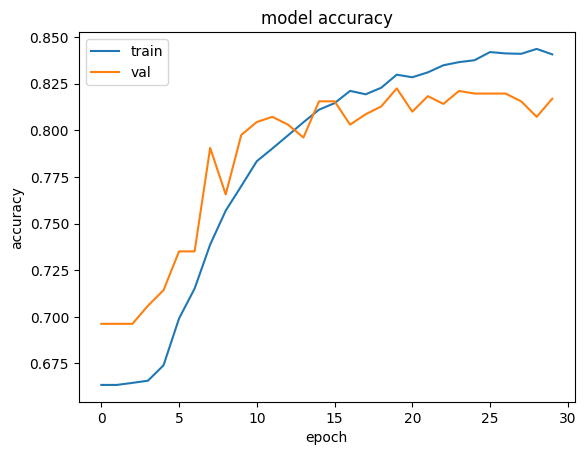

In [394]:
print(model_cbow.history.history.keys())
# summarize history for accuracy
plt.plot(model_cbow.history.history['accuracy'])
plt.plot(model_cbow.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [396]:
max(model_cbow.history.history['accuracy'])

0.8436198830604553

In [443]:
max(model_skip.history.history['accuracy'])

0.8642904162406921

In [444]:
max(model_w2v.history.history['accuracy'])

0.8592506051063538

In [445]:
max(model_ft.history.history['accuracy'])

0.8577167391777039

# rus_vectores я либо что-то не понял, либо так и должно

In [434]:
import gensim
model_pre = gensim.models.KeyedVectors.load_word2vec_format('180/model.bin', binary=True)

In [435]:
# Create a weight matrix for the Embedding layer
embedding_matrix = np.zeros((len(word2id), model_pre.vector_size))
for word, i in word2id.items():
    if word in model_pre:
        embedding_matrix[i] = model_pre[word]

In [438]:
# Create an Embedding layer with the pre-trained weights
embedding_layer = tf.keras.layers.Embedding(input_dim=len(word2id),
                            output_dim=model_pre.vector_size,
                            weights=[embedding_matrix],
                            trainable=False)

In [439]:
# Use the Embedding layer in your classification model
inputs = tf.keras.layers.Input(shape=(None,))
embeddings = embedding_layer(inputs)
mean = tf.keras.layers.GlobalAveragePooling1D()(embeddings)
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(mean)
clf = tf.keras.Model(inputs=inputs, outputs=outputs)
optimizer = tf.keras.optimizers.Adam()
clf.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [440]:
X = []
for tokens in data['norm_text']:
    ids = [word2id[token] for token in tokens if token in word2id]
    X.append(ids)
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=300)
y = data.toxic.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [441]:
clf.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=30)

Epoch 1/30
428/428 [==============================] - 2s 3ms/step - loss: 0.6696 - accuracy: 0.6643 - val_loss: 0.6479 - val_accuracy: 0.6810
Epoch 2/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6460 - accuracy: 0.6643 - val_loss: 0.6327 - val_accuracy: 0.6810
Epoch 3/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6397 - accuracy: 0.6643 - val_loss: 0.6285 - val_accuracy: 0.6810
Epoch 4/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6384 - accuracy: 0.6643 - val_loss: 0.6272 - val_accuracy: 0.6810
Epoch 5/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6382 - accuracy: 0.6643 - val_loss: 0.6268 - val_accuracy: 0.6810
Epoch 6/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6382 - accuracy: 0.6643 - val_loss: 0.6268 - val_accuracy: 0.6810
Epoch 7/30
428/428 [==============================] - 1s 3ms/step - loss: 0.6382 - accuracy: 0.6643 - val_loss: 0.6266 - val_accuracy: 0.6810
Epoch 

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


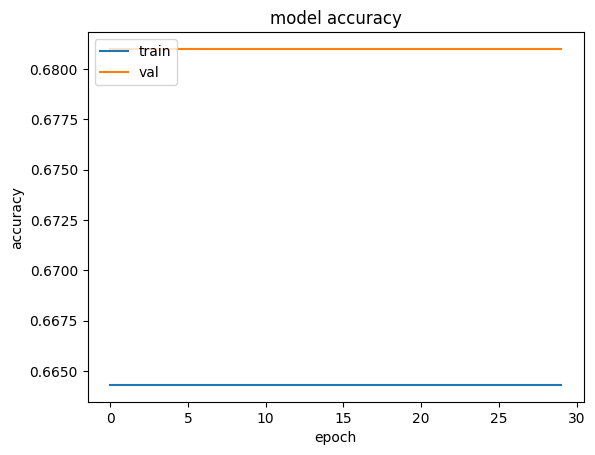

In [442]:
print(clf.history.history.keys())
# summarize history for accuracy
plt.plot(clf.history.history['accuracy'])
plt.plot(clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [425]:
def text_embedding(tokens):
    # Initialize an array to store the embeddings
    embeddings = np.zeros((1, model_pre.vector_size))

    # Compute the average embedding for the text
    count = 0
    for token in tokens:
        if token in model_pre:
            embeddings += model_pre[token]
            count += 1
    if count > 0:
        embeddings /= count

    return embeddings

In [426]:
X = np.concatenate([text_embedding(tokens) for tokens in data['norm_text']])
y = data.toxic.values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.05)

In [428]:
# Create an input layer with the correct shape
inputs = tf.keras.layers.Input(shape=(model_pre.vector_size,))

# Create an output layer
outputs = tf.keras.layers.Dense(1, activation='sigmoid')(inputs)

# Create a model
clf = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = tf.keras.optimizers.Adam()
clf.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [430]:
clf.fit(X_train, y_train, validation_data=(X_valid, y_valid), batch_size=32, epochs=30)

Epoch 1/30
428/428 [==============================] - 1s 966us/step - loss: 0.6688 - accuracy: 0.6647 - val_loss: 0.6498 - val_accuracy: 0.6727
Epoch 2/30
428/428 [==============================] - 0s 743us/step - loss: 0.6456 - accuracy: 0.6647 - val_loss: 0.6371 - val_accuracy: 0.6727
Epoch 3/30
428/428 [==============================] - 0s 702us/step - loss: 0.6395 - accuracy: 0.6647 - val_loss: 0.6337 - val_accuracy: 0.6727
Epoch 4/30
428/428 [==============================] - 0s 893us/step - loss: 0.6381 - accuracy: 0.6647 - val_loss: 0.6327 - val_accuracy: 0.6727
Epoch 5/30
428/428 [==============================] - 0s 691us/step - loss: 0.6379 - accuracy: 0.6647 - val_loss: 0.6324 - val_accuracy: 0.6727
Epoch 6/30
428/428 [==============================] - 0s 739us/step - loss: 0.6379 - accuracy: 0.6647 - val_loss: 0.6324 - val_accuracy: 0.6727
Epoch 7/30
428/428 [==============================] - 0s 714us/step - loss: 0.6379 - accuracy: 0.6647 - val_loss: 0.6324 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


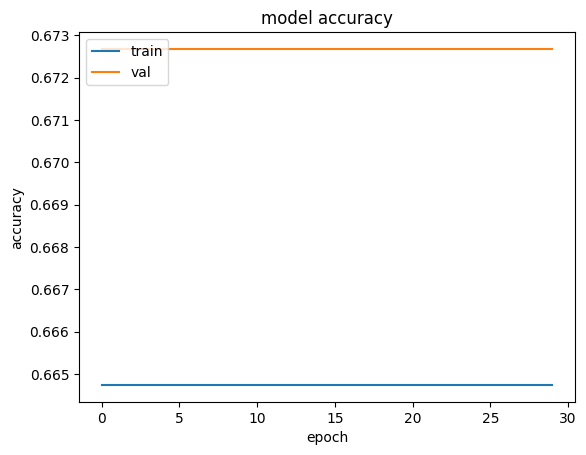

In [431]:
print(clf.history.history.keys())
# summarize history for accuracy
plt.plot(clf.history.history['accuracy'])
plt.plot(clf.history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()